# Predict Daily Temperatures in Jena 

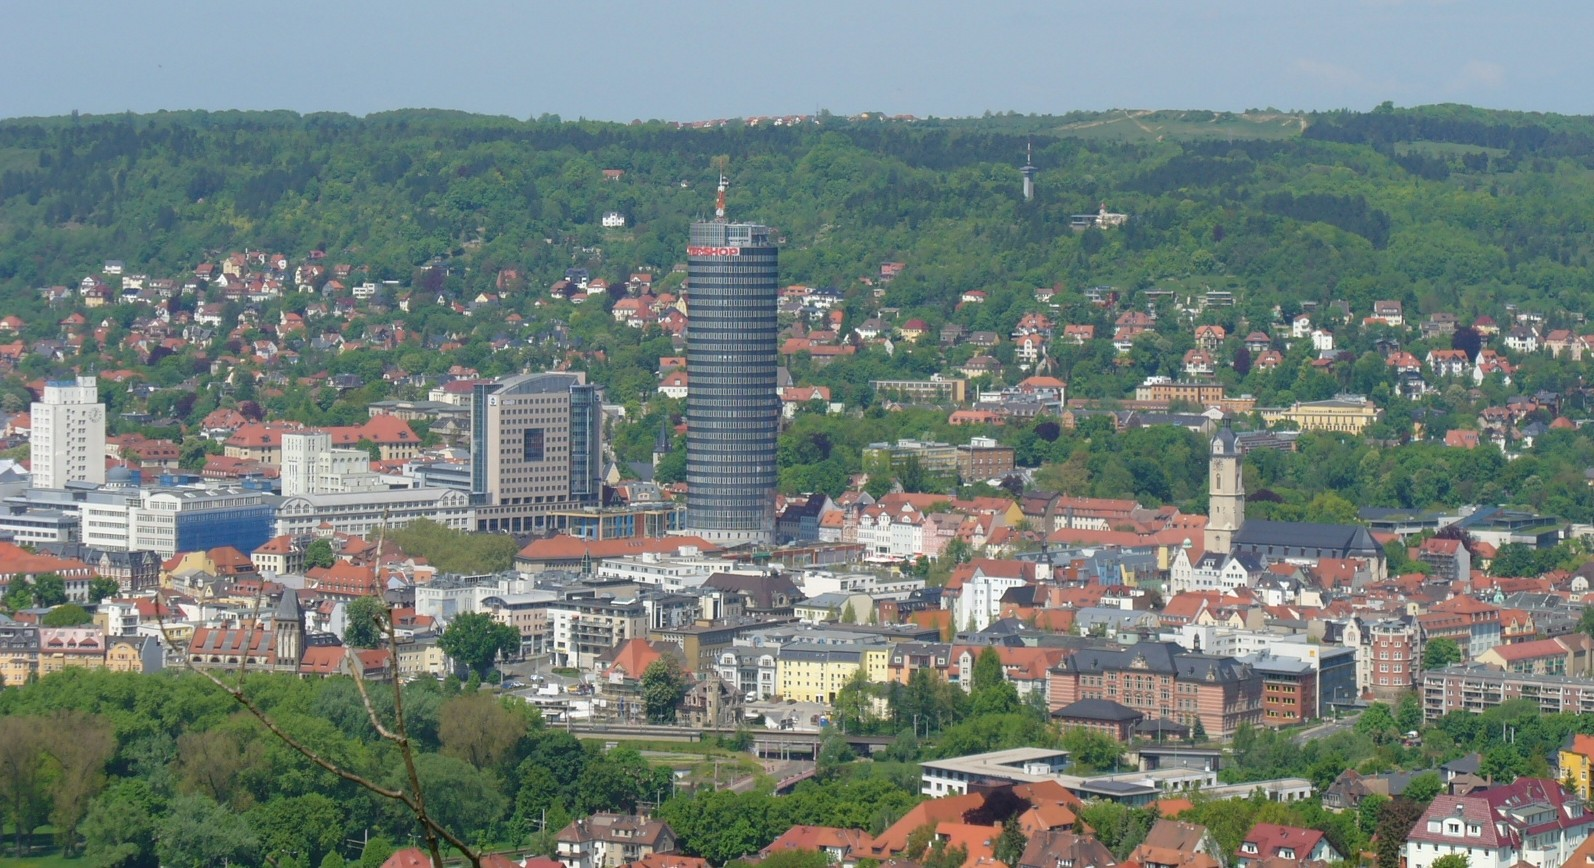

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
from utils.utils import generator_timeseries

In [2]:
db = pd.read_csv("./data/jena_climate_2009_2016.csv")

In [3]:
db.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [4]:
db.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


<AxesSubplot:>

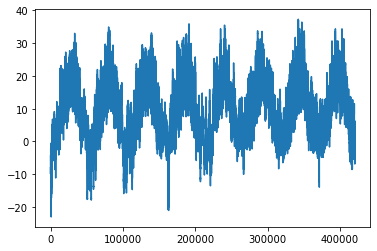

In [5]:
db['T (degC)'].plot()

### Ex1:

Play with visualization. Use pandas or seaborn or any other library of your choice in order to explore the dataset through graphs and basic statistics. Which variables show periodicity and at what scales? Which are the most relevant variables to predict temperature? Do your results confirm what you would expect? (Hints: put datetime as x axis, look at daily or monthly or seasonal trends, study correlations among variables, etc.).

<AxesSubplot:>

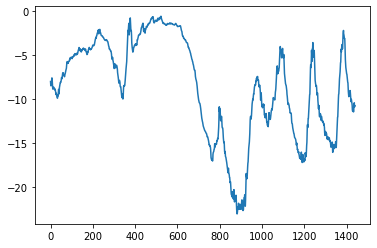

In [6]:
db['T (degC)'][:1440].plot()

## Prepare data for training

In [7]:
float_data = db.drop(columns = ['Date Time']).to_numpy(dtype="float")
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [10]:
train_gen = generator_timeseries(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator_timeseries(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator_timeseries(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [11]:
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [12]:
for samples, targets in train_gen:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (128, 240, 14)
targets shape: (128,)


## Baselines

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

In [15]:
print("Baseline error = ", "{:.2f}".format(evaluate_naive_method()*std[1]), "(degC)")

Baseline error =  2.56 (degC)


In [25]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) 
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [27]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer=RMSprop(), loss='mae') 
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=10, 
                              validation_data=val_gen, validation_steps=val_steps // batch_size)

Epoch 1/10
500/500 [==============================] - 13s 26ms/step - loss: 2.0177 - val_loss: 0.4146
Epoch 2/10
500/500 [==============================] - 13s 26ms/step - loss: 0.4774 - val_loss: 0.3206
Epoch 3/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2938 - val_loss: 0.2957
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2636 - val_loss: 0.3090
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2489 - val_loss: 0.3477
Epoch 6/10
500/500 [==============================] - 13s 27ms/step - loss: 0.2444 - val_loss: 0.3081
Epoch 7/10
500/500 [==============================] - 13s 26ms/step - loss: 0.2344 - val_loss: 0.3268
Epoch 8/10
500/500 [==============================] - 13s 27ms/step - loss: 0.2321 - val_loss: 0.3254
Epoch 9/10
500/500 [==============================] - 13s 27ms/step - loss: 0.2264 - val_loss: 0.3225
Epoch 10/10
500/500 [==============================] - 14s 27ms/step - loss: 0.224

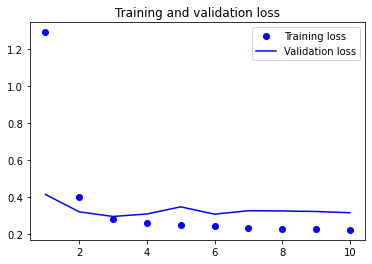

In [30]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
print("FCNN error = ", "{:.2f}".format(np.min(val_loss)*std[1]), "(degC)")

FCNN error =  2.62 (degC)


### Ex2:

Modify the code above to use tensorboard. 

### Ex3: 

Try to improve the baselines models (Hint: play with the architecture or hyperparameters, use some ML models, add preprocessing steps and feature engineering). 

## Recurrent Neural Networks 

In [35]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [36]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [37]:

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,steps_per_epoch=500,
                                      epochs=10,
                                      validation_data=val_gen,
                                      validation_steps=val_steps // batch_size)

Epoch 1/10
500/500 [==============================] - 105s 206ms/step - loss: 0.3245 - val_loss: 0.2764
Epoch 2/10
500/500 [==============================] - 99s 197ms/step - loss: 0.2841 - val_loss: 0.2645
Epoch 3/10
500/500 [==============================] - 86s 172ms/step - loss: 0.2800 - val_loss: 0.2619
Epoch 4/10
500/500 [==============================] - 85s 170ms/step - loss: 0.2762 - val_loss: 0.2630
Epoch 5/10
500/500 [==============================] - 81s 161ms/step - loss: 0.2671 - val_loss: 0.2661
Epoch 6/10
500/500 [==============================] - 79s 158ms/step - loss: 0.2666 - val_loss: 0.2646
Epoch 7/10
500/500 [==============================] - 82s 164ms/step - loss: 0.2626 - val_loss: 0.2683
Epoch 8/10
500/500 [==============================] - 81s 162ms/step - loss: 0.2588 - val_loss: 0.2677
Epoch 9/10
500/500 [==============================] - 76s 152ms/step - loss: 0.2534 - val_loss: 0.2693
Epoch 10/10
500/500 [==============================] - 74s 147ms/step - 

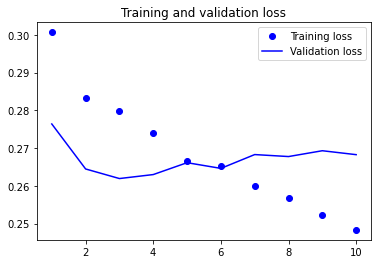

In [38]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
print("RNN error = ", "{:.2f}".format(np.min(val_loss)*std[1]), "(degC)")

RNN error =  2.32 (degC)


### Ex4: 

Pick a technique of your choice to reduce overfitting and train again the model. 

In [40]:
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6016      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit_generator(train_gen,steps_per_epoch=500,
                                      epochs=10,
                                      validation_data=val_gen,
                                      validation_steps=val_steps // batch_size)

Epoch 1/10
500/500 [==============================] - 92s 181ms/step - loss: 0.3265 - val_loss: 0.2743
Epoch 2/10
500/500 [==============================] - 93s 187ms/step - loss: 0.2755 - val_loss: 0.2664
Epoch 3/10
500/500 [==============================] - 89s 178ms/step - loss: 0.2625 - val_loss: 0.2675
Epoch 4/10
500/500 [==============================] - 102s 204ms/step - loss: 0.2519 - val_loss: 0.2809
Epoch 5/10
500/500 [==============================] - 97s 193ms/step - loss: 0.2457 - val_loss: 0.2731
Epoch 6/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2373 - val_loss: 0.2768
Epoch 7/10
500/500 [==============================] - 98s 196ms/step - loss: 0.2316 - val_loss: 0.2847
Epoch 8/10
500/500 [==============================] - 79s 158ms/step - loss: 0.2252 - val_loss: 0.2915
Epoch 9/10
500/500 [==============================] - 78s 155ms/step - loss: 0.2207 - val_loss: 0.2944
Epoch 10/10
500/500 [==============================] - 82s 164ms/step - 

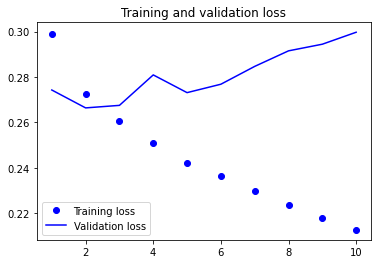

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [46]:
print("RNN error = ", "{:.2f}".format(np.min(val_loss)*std[1]), "(degC)")

RNN error =  2.36 (degC)


### Ex5:

Increase the capacity of the RNN models by adding multiple recurrent layers. Find a balance between overfitting and performance. Optimize the hyperparameters. 

### Ex6:

Try to improve the performance of the RNN models by changing the input sample configuration. (Hint: consider longer time series). 